# Understanding AC-GANs in Keras

Luke de Oliveira (`lukedeo@vaitech.io`)

### Background
Auxiliary Classifier Generative Adversarial Networks (AC-GANs for short), [introduced by Odena, et al.](https://arxiv.org/abs/1610.09585), are an extension of the GAN framework proposed by [Goodfellow, et al.](https://arxiv.org/abs/1406.2661) in 2014. TL;DR, an AC-GAN makes the latent $z$ space conditional upon a class label, and forces the generator network to jointly learn to identify fake from non-fake images as well the task of correctly identifying the class of the image, fake or not. In not-too-hard-to-understand math, we have that the generator takes as input a latent vector and a class and produces an image in image-space, $\mathcal{I}$. 

$$
g: (z, \ell) \longrightarrow M
$$

Where $z\in\mathbb{R}^D$, $M\in\mathcal{I}$, and $\ell\in\mathcal{L}$, the space of labels.

To ground what "image space" means, note that for MNIST, $\mathcal{I}\subset (\mathbb{N}\cup {0})^{28 \times 28}$, i.e., 28 x 28 `uint8`s.

In this setup, the discriminator performs the following mapping

$$
d: M \longrightarrow (f, h_{\ell})
$$

Where $M\in\mathcal{I}$, $f\in\{0, 1\}$ is whether or not $M$ is considered to be fake or not, and $h_{\ell}\in\mathcal{L}$ is the hypothesized label that was fed to $g$.

In a pretty picture, this looks like this (look at the far right):

![GAN Diagram](https://pbs.twimg.com/media/CwM0BzjVUAAWTn4.jpg:large "Space of GANS (AC-GAN on the right)")


### Understanding AC-GANs

Consult [the MNIST example](./mnist_acgan.py) for training and setup the models required for the set up. I'm going to assume you've run the example, have a bunch of HDF5 files lying around, as well as a file called `acgan-history.pkl`, which contains, you guessed it, the training history from the GAN. The two competing nets in the GAN world are competing for an equilibrium (in the game theoretic sense) so it makes sense to look at how the loss functions look in comparison to the Nash Equilibrium (consult [this paper](https://arxiv.org/pdf/1406.2661v1.pdf) for the derivation of the Nash Equilibrium).

**To run through this notebook, you'll need Python 2 or 3, numpy, matplotlib, pandas, and Keras.**

In [1]:
import cPickle as pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
hist = pickle.load(open('./acgan-history.pkl'))

In [4]:
losses = ['loss', 'generation_loss', 'auxiliary_loss']

In [5]:
for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        hist[p][g] = pd.DataFrame(hist[p][g], columns=losses)

First, we'll look at the generation loss, i.e., the loss associated with tricking the discriminator into thinking that a fake image is a real image.

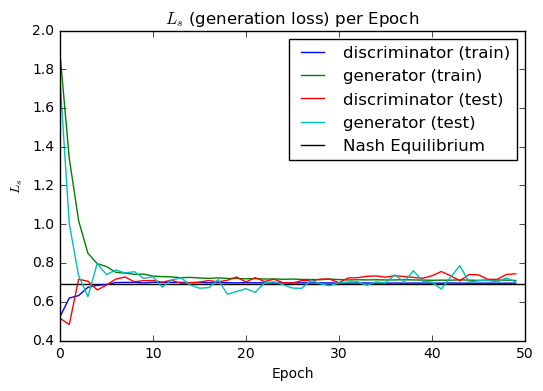

In [6]:
for p in ['train', 'test']:
    for g in ['discriminator', 'generator']:
        plt.plot(hist[p][g]['generation_loss'], label='{} ({})'.format(g, p))

# get the NE and show as an equilibrium point
plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend()
plt.title(r'$L_s$ (generation loss) per Epoch')
plt.xlabel('Epoch')
plt.ylabel(r'$L_s$')

We can see above that at the ~15th or so Epoch, the training losses have converged to the Nash Equilibrium point. We see some shaky behavior from the test loss on the generator, but this is to be expected.

Now, let's look at the auxiliary loss, i.e., loss associated with the discriminator getting the correct label. Note that both networks are trying to *minimize* this quantity.

[]

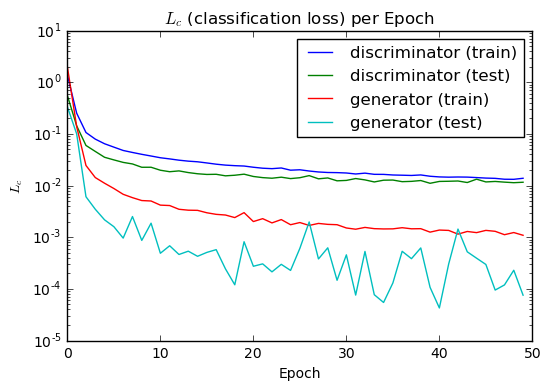

In [7]:
for g in ['discriminator', 'generator']:
    for p in ['train', 'test']:
        plt.plot(hist[p][g]['auxiliary_loss'], label='{} ({})'.format(g, p))
        
# plt.hlines(-np.log(0.5), 0, hist[p][g]['generation_loss'].shape[0], label='Nash Equilibrium')
plt.legend()
plt.title(r'$L_c$ (classification loss) per Epoch')
plt.xlabel('Epoch')
plt.ylabel(r'$L_c$')
plt.semilogy()

### GAN output

Let's  take a look at the output of the generator to see what the digits look like.

In [8]:
from mnist_acgan import build_generator, build_discriminator
from glob import glob

latent_size = 100

Using TensorFlow backend.


In [9]:
g = build_generator(latent_size)

In [10]:
# load the weights from the last epoch
g.load_weights(sorted(glob('params_generator*'))[-1])

We will make a 10 x 10 grid of generated MNIST digits, where each row is one sampling of $z$, and each column is that same latend vector, just conditioned by the associated digit.

In [15]:
np.random.seed(31337)

noise = np.tile(np.random.uniform(-1, 1, (10, latent_size)), (10, 1))
print noise[0]
sampled_labels = np.array([
    [i] * 10 for i in range(10)
]).reshape(-1, 1, 1)

# get a batch to display
generated_images = g.predict(
    [noise, sampled_labels], verbose=0)

# arrange them into a grid
img = (np.concatenate([r.reshape(-1, 28)
                       for r in np.split(generated_images, 10)
                       ], axis=-1) * 127.5 + 127.5).astype(np.uint8)


[ 0.97440824 -0.12448376 -0.86946328 -0.3504764  -0.8282886   0.56260572
  0.65066212 -0.93874725  0.32850231  0.40440754 -0.52224723 -0.12083246
  0.99656799  0.75142039  0.3533643   0.27089635  0.68860309 -0.26528859
 -0.1803225   0.89050444 -0.08165463 -0.32635211  0.34474768 -0.11885296
  0.50645379 -0.21798377  0.21058684 -0.61975692 -0.73673928  0.76785503
  0.98510116 -0.49942454 -0.37164075 -0.39747379  0.36646863 -0.67069406
  0.43721602  0.20255524 -0.7969709   0.20107834  0.53700981 -0.87989055
 -0.86272254  0.99376787  0.34526832 -0.9277184  -0.10823292  0.09042413
 -0.15875392  0.25098212  0.64226847 -0.21002834 -0.50047228  0.03648292
 -0.98661041 -0.59021526  0.319942   -0.42583286 -0.44653841  0.14529102
 -0.13212423 -0.71174378  0.98997787  0.93718638 -0.05683531  0.48047514
  0.32408123  0.43077766  0.0344332  -0.50645397  0.00656187  0.91085064
  0.42316869 -0.98353592 -0.18180179 -0.12955274  0.75417154 -0.14312771
 -0.35582874  0.54186419  0.83851228 -0.69569696  0

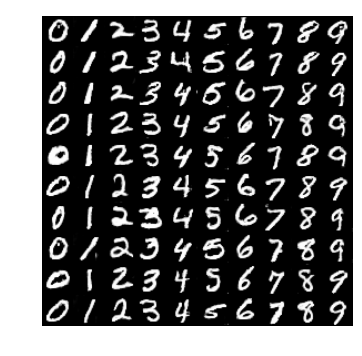

In [12]:
plt.imshow(img, cmap='gray')#, interpolation='nearest')
_ = plt.axis('off')

In [13]:
def make_digit(digit=None):
    noise = np.random.uniform(-1, 1, (1, latent_size))

    sampled_label = np.array([
            digit if digit is not None else np.random.randint(0, 10, 1)
        ]).reshape(-1, 1, 1)

    generated_image = g.predict(
        [noise, sampled_label], verbose=0)

    return np.squeeze((generated_image * 127.5 + 127.5).astype(np.uint8))

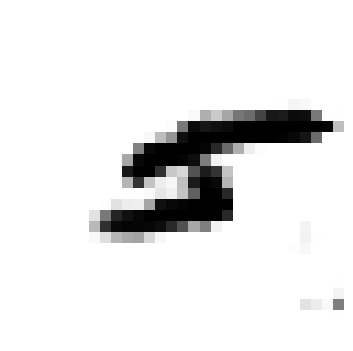

In [14]:
plt.imshow(make_digit(digit=9), cmap='gray_r', interpolation='nearest')
_ = plt.axis('off')